<a href="https://colab.research.google.com/github/ada-my619/Seismic_Facies_Interpretation/blob/main/Seismic_Facies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycm livelossplot
%pylab inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary


import matplotlib.pyplot as plt
import numpy as np
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.4/610.4 kB 20.8 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [2]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [3]:
set_seed(42)

True

In [1]:
# download the files:
!wget https://zenodo.org/record/3755060/files/data.zip
# check that the md5 checksum matches:
!openssl dgst -md5 data.zip # Make sure the result looks like this: MD5(data.zip)= bc5932279831a95c0b244fd765376d85, otherwise the downloaded data.zip is corrupted.
# unzip the data:
!unzip data.zip
# create a directory where the train/val/test splits will be stored:
!mkdir data/splits

--2025-12-30 19:47:39--  https://zenodo.org/record/3755060/files/data.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 137.138.52.235, 188.185.43.153, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3755060/files/data.zip [following]
--2025-12-30 19:47:40--  https://zenodo.org/records/3755060/files/data.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1051449986 (1003M) [application/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1003M  1.59MB/s    in 10m 29s 

2025-12-30 19:58:09 (1.59 MB/s) - ‘data.zip’ saved [1051449986/1051449986]

MD5(data.zip)= bc5932279831a95c0b244fd765376d85
Archive:  data.zip
   creating: data/
   creating: data/train/
  inflating: data/train/train_seismic.npy  
  inflating: data/train/train_labels.npy  
   creating: data/test_once/
  inflating: data/tes

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [206]:
# !cp ./data.zip /content/drive/MyDrive/data.zip

  adding: content/data.zip (stored 0%)


In [5]:
!ls -lh /content/drive/MyDrive/

total 1003M
drwx------ 2 root root  4.0K Nov 26 11:23 'Colab Notebooks'
-rw------- 1 root root 1003M Dec 30 21:36  data.zip
-rw------- 1 root root    67 Nov 25 17:01  kaggle.json
drwx------ 2 root root  4.0K Nov 26 14:28  models
drwx------ 2 root root  4.0K Dec 30 21:34  seismic_project


In [6]:
!cp /content/drive/MyDrive/data.zip .

In [9]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/train/
  inflating: data/train/train_seismic.npy  
  inflating: data/train/train_labels.npy  
   creating: data/test_once/
  inflating: data/test_once/test1_seismic.npy  
  inflating: data/test_once/test2_labels.npy  
  inflating: data/test_once/test1_labels.npy  
  inflating: data/test_once/test2_seismic.npy  
  inflating: data/.dropbox           


In [10]:
from matplotlib import pyplot as plt
import numpy as np

train_seismic = np.load('data/train/train_seismic.npy')
train_labels = np.load('data/train/train_labels.npy')
train_seismic.shape, train_labels.shape

((401, 701, 255), (401, 701, 255))

In [11]:
class SeismicSliceDataset(Dataset):
    def __init__(self, seismic_path, labels_path, axis=0, transform=None):
        self.seis = np.load(seismic_path)   # memory-friendly
        self.lab  = np.load(labels_path)
        assert self.seis.shape == self.lab.shape
        self.axis = axis
        self.transform = transform

        self.n = self.seis.shape[axis]  # number of slices

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        # take a slice along chosen axis
        x = np.take(self.seis, idx, axis=self.axis)  # (401,701) if axis=2
        y = np.take(self.lab,  idx, axis=self.axis)

        # convert types
        x = torch.from_numpy(np.array(x)).float().unsqueeze(0)  # (1,H,W)
        y = torch.from_numpy(np.array(y)).float().unsqueeze(0)                # (H,W) for CE loss

        if self.transform:
            x, y = self.transform(x, y)

        return x, y

In [12]:
train_dataset = SeismicSliceDataset(seismic_path='data/train/train_seismic.npy', labels_path='data/train/train_labels.npy')
train_dataset

In [13]:
len(train_dataset)

401

In [14]:
train_dataset[0][0].shape

torch.Size([1, 701, 255])

torch.Size([1, 701, 255])


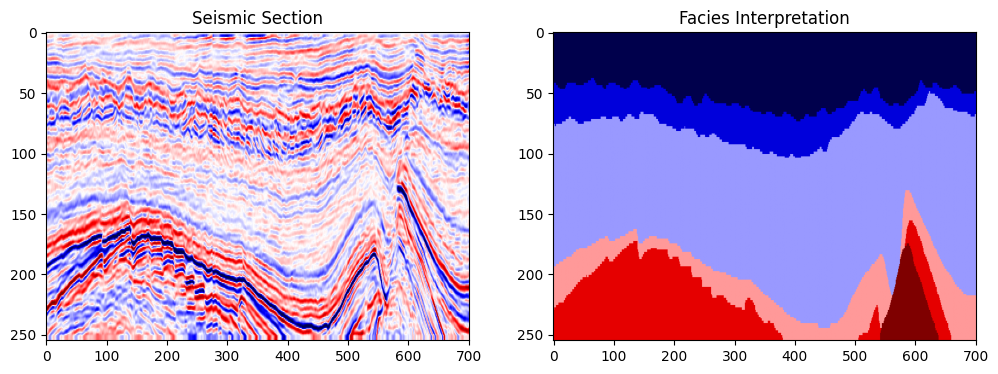

In [15]:
x, y = train_dataset[0]
print(y.shape)
fig = plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(x.permute(2, 1, 0).numpy(), cmap='seismic', aspect='auto')
ax1.set_title('Seismic Section')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(y.permute(2, 1, 0).numpy(), cmap='seismic', aspect='auto')
ax2.set_title('Facies Interpretation')

plt.show()

In [16]:
from torch.utils.data import Subset

n_total = len(train_dataset)
split_idx = int(0.8 * n_total)

train_indices = list(range(0, split_idx))
val_indices   = list(range(split_idx, n_total))

train_ds = Subset(train_dataset, train_indices)
val_ds   = Subset(train_dataset, val_indices)

torch.Size([1, 701, 255])


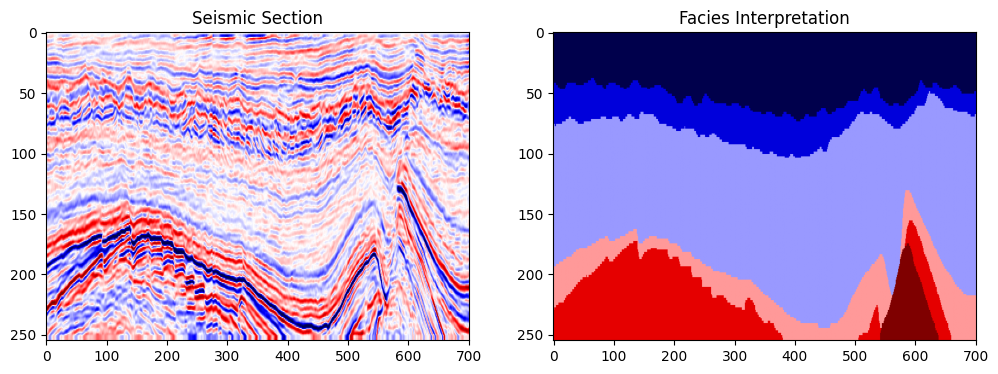

In [17]:
x, y = train_ds[0]
print(y.shape)
fig = plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(x.permute(2, 1, 0).numpy(), cmap='seismic', aspect='auto')
ax1.set_title('Seismic Section')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(y.permute(2, 1, 0).numpy(), cmap='seismic', aspect='auto')
ax2.set_title('Facies Interpretation')

plt.show()

In [18]:
batch_size = 8

In [19]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

In [20]:
import torch.nn as nn

class ConvBlock(nn.Module):
  def __init__(self, input_channel, output_channel):
    super().__init__()
    self.c = nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=3, padding=1)
    self.bn = nn.BatchNorm2d(output_channel)
    self.activation = nn.SiLU()

  def forward(self, x):
    x = self.c(x)
    x = self.bn(x)
    x = self.activation(x)
    return x

class DecBlock(nn.Module):
  def __init__(self, input_channel, output_channel):
    super().__init__()
    self.up = nn.ConvTranspose2d(input_channel, output_channel, kernel_size=2, stride=2, padding=0)
    self.conv_block1 = ConvBlock(output_channel * 2, output_channel) # 2 times for handling skip connection, double the channel size since we concat on the channel dim
    self.conv_block2 = ConvBlock(output_channel, output_channel)

  def forward(self, x, s):
    h = self.up(x)
    h = torch.cat([h, s], axis=1)
    h = self.conv_block1(h)
    h = self.conv_block2(h)
    return h

class EncBlock(nn.Module):
  def __init__(self, input_channel, output_channel):
    super().__init__()
    self.conv_block1 = ConvBlock(input_channel, output_channel)
    self.conv_block2 = ConvBlock(output_channel, output_channel)
    self.pool = nn.MaxPool2d((2, 2))

  def forward(self, x):
    h = self.conv_block1(x)
    h = self.conv_block2(h)
    p = self.pool(h)
    return h, p


In [21]:
class UNet(nn.Module):
    def __init__(self, n_channels = 1):
      super().__init__()
      self.e1 = EncBlock(n_channels, 8)
      self.e2 = EncBlock(8, 16)
      self.e3 = EncBlock(16, 32)
      self.e4 = EncBlock(32, 64)
      self.b1 = ConvBlock(64, 128)
      self.d1 = DecBlock(128, 64)
      self.d2 = DecBlock(64, 32)
      self.d3 = DecBlock(32, 16)
      self.d4 = DecBlock(16, 8)
      self.output = nn.Conv2d(8, n_channels, kernel_size=1, padding=0) # we keep the size, just reduce the channels

    def forward(self, x):
      B, C, H, W = x.shape
      # print(B, C, H, W)
      # --- auto pad to multiples of 16 ---
      pad_h = (16 - H % 16) % 16
      pad_w = (16 - W % 16) % 16

      x = F.pad(x, (0, pad_w, 0, pad_h))  # (left,right,top,bottom)

      s1, x = self.e1(x)
      s2, x = self.e2(x)
      s3, x = self.e3(x)
      s4, x = self.e4(x)
      x = self.b1(x)
      x = self.d1(x, s4)
      x = self.d2(x, s3)
      x = self.d3(x, s2)
      x = self.d4(x, s1)
      output = self.output(x)
      output = output[:, :, :H, :W]
      # print(output.shape)
      return output

In [22]:
unet = UNet(n_channels=1).to(device)
unet

UNet(
  (e1): EncBlock(
    (conv_block1): ConvBlock(
      (c): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (conv_block2): ConvBlock(
      (c): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): EncBlock(
    (conv_block1): ConvBlock(
      (c): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (conv_block2): ConvBlock(
      (c): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=T

In [23]:
summary(unet, (1, 701, 255))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 704, 256]              80
       BatchNorm2d-2          [-1, 8, 704, 256]              16
              SiLU-3          [-1, 8, 704, 256]               0
         ConvBlock-4          [-1, 8, 704, 256]               0
            Conv2d-5          [-1, 8, 704, 256]             584
       BatchNorm2d-6          [-1, 8, 704, 256]              16
              SiLU-7          [-1, 8, 704, 256]               0
         ConvBlock-8          [-1, 8, 704, 256]               0
         MaxPool2d-9          [-1, 8, 352, 128]               0
         EncBlock-10  [[-1, 8, 704, 256], [-1, 8, 352, 128]]               0
           Conv2d-11         [-1, 16, 352, 128]           1,168
      BatchNorm2d-12         [-1, 16, 352, 128]              32
             SiLU-13         [-1, 16, 352, 128]               0
        ConvBlock-14      

In [24]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss = 0.
    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        train_loss += loss*x.size(0)
        optimizer.step()
    train_loss = train_loss / len(data_loader.dataset)
    return train_loss


def valid(model, criterion, data_loader):
    model.eval()
    valid_loss = 0.
    with torch.no_grad():
        for x, y in data_loader:
          x, y = x.to(device), y.to(device)
          output = model(x)
          loss = criterion(output, y)
          valid_loss += loss*x.size(0)
        valid_loss = valid_loss / len(data_loader.dataset)
        return valid_loss


In [28]:
lr = 1e-3
nepochs = 10

In [29]:
optimiser = torch.optim.Adam(params=unet.parameters(), lr=lr)
mseloss = nn.MSELoss()

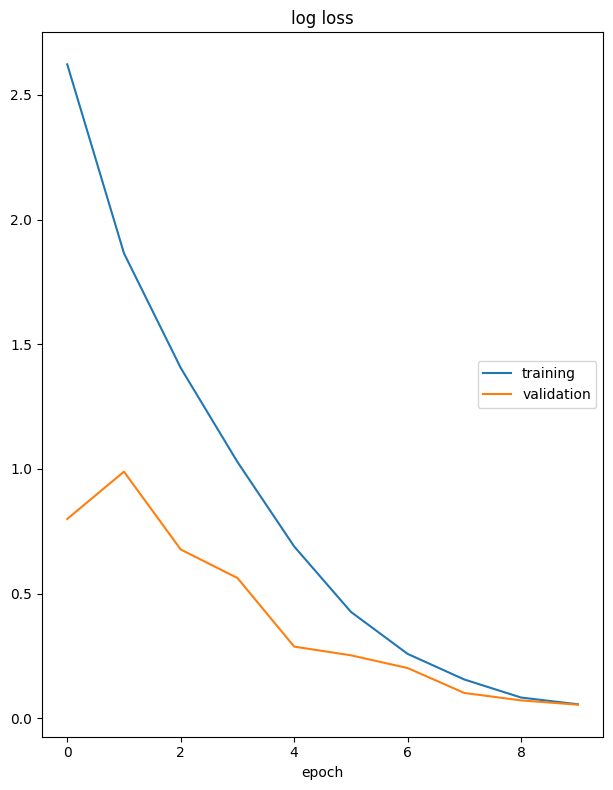

100%|██████████| 10/10 [01:37<00:00,  9.76s/it]

log loss
	training         	 (min:    0.056, max:    2.623, cur:    0.056)
	validation       	 (min:    0.054, max:    0.989, cur:    0.054)


In [30]:
from tqdm import tqdm

liveloss = PlotLosses()
for i in tqdm(range(nepochs)):
    train_loss = train(unet, optimiser, mseloss, train_loader)
    valid_loss = valid(unet, mseloss, val_loader)

    # Liveloss plot
    logs = {}
    logs['' + 'log loss'] = train_loss.item()
    logs['val_' + 'log loss'] = valid_loss.item()
    liveloss.update(logs)
    liveloss.draw()

In [31]:
# get the test dataset and labels
test_dataset = SeismicSliceDataset(seismic_path='data/test_once/test1_seismic.npy', labels_path='data/test_once/test1_labels.npy')
test_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

In [51]:
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            pred = model(X)
            ys.append(y.cpu())
            y_preds.append(pred.cpu())

    return torch.from_numpy(np.concatenate(y_preds, 0)),  torch.from_numpy(np.concatenate(ys, 0))

In [52]:
# make a prediction
pred, real = evaluate(unet, test_loader)
pred.shape, real.shape

(torch.Size([81, 1, 701, 255]), torch.Size([81, 1, 701, 255]))

In [55]:
pred[0].shape, real[0].shape

(torch.Size([1, 701, 255]), torch.Size([1, 701, 255]))

Text(0.5, 1.0, 'Facies Interpretation')

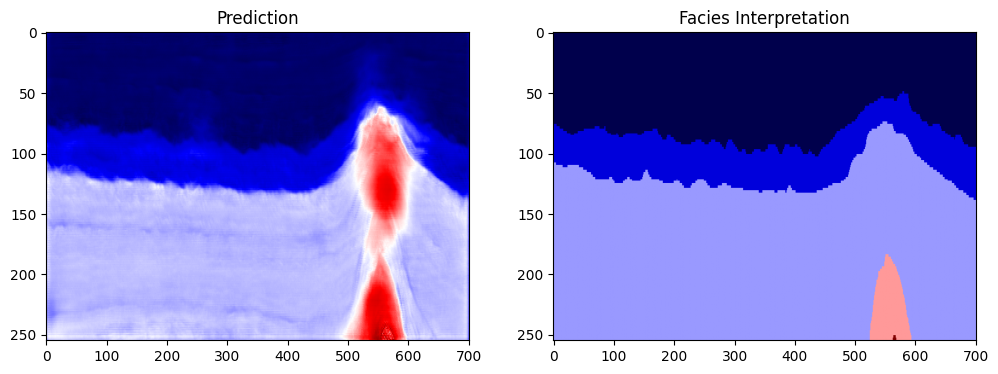

In [61]:
# plot the pred and real side by side
fig = plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(pred[50].permute(2, 1, 0), cmap='seismic', aspect='auto')
ax1.set_title('Prediction')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(real[50].permute(2, 1, 0), cmap='seismic', aspect='auto')
ax2.set_title('Facies Interpretation')